## Getting things started

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import time

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# Uploading 3 sample files
files.upload()

In [0]:
# Reading images from the uploaded files
t1 = np.asarray(cv.imread("/content/t1.jpg"))
t2 = np.asarray(cv.imread("/content/t2.jpg"))
t3 = np.asarray(cv.imread("/content/t3.jpg"))

# Reading images as grayscale
t1_gray = np.asarray(cv.imread("/content/t1.jpg", 0))
t2_gray = np.asarray(cv.imread("/content/t2.jpg", 0))
t3_gray = np.asarray(cv.imread("/content/t3.jpg", 0))

## Otsu's Method for Binarization of Image

In [0]:
# Initializing class probabilities
def class_prob(x):
  uT = np.zeros(x.shape)
  for i in range(x.size):
    uT[i] = (i+1)*x[i]
  return uT


'''
t: threshold
Iterating over threshold, computing running max
Otsu Thresholding:
Parameters: Class Probability (p), Class Mean (uT)
Output: Maximum Inter-class variance threshold(sig)
'''
def otsu(p, uT):
  sig = 0
  otsu_t = 0
  for t in np.arange(p.size):
    w0 = np.sum(p[:t])
    w1 = np.sum(p[t:])
    u0 = np.sum(uT[:t]) / w0
    u1 = np.sum(uT[t:]) / w1
    
    # Computing Inter-class variance
    sig_new = w0*w1*((u0 - u1)**2)
    
    # If a new maximum is encountered
    if (sig_new > sig):
      otsu_t = t
      sig = sig_new    
  return otsu_t


''' 
Image Binarization
Set values over the threshold as 1, others as 0
'''
def img_bin(img, t):
  h, w = img.shape
  x = img.flatten()
  for i in range(x.size):
    if (x[i] > t): 
      x[i] = 1
    else: 
      x[i] = 0
  return (x.reshape(h, w))

In [0]:
def otsu_wrapper(img):
  img_hist, img_bins = np.histogram(img, bins=(np.max(img)-np.min(img)))
  img_p = img_hist / np.sum(img_hist)
  
#   # Plot Probability Distribution of Intensities 
#   plt.plot(img_p)
#   plt.show()
  
  # uT = i*p(i) for all class probabilities
  img_ut = class_prob(img_p)
  
  # Plotting thresholds over class probabilities
  plt.plot(img_p)
  otsu_t = otsu(img_p, img_ut)
  x = [otsu_t]* int(np.round((np.max(img_p)/0.0001 + 1)))
  plt.plot(x, np.arange(np.max(img_p), step = 0.0001))
  plt.show()
  
  plt.imshow(img)
  plt.show()
  plt.imshow(img_bin(img, otsu_t))
  plt.show()
  print(otsu_t)

In [0]:
start_time = time.time()
otsu_wrapper(t1_gray)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
otsu_wrapper(t2_gray)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
otsu_wrapper(t3_gray)
print("--- %s seconds ---" % (time.time() - start_time))

References: 
1. Otsu's Method Algorithm: https://en.wikipedia.org/wiki/Otsu%27s_method#Algorithm
2. NumPy Documentation: https://docs.scipy.org/doc/numpy/
3. Matplotlib Documentation: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.html

## Quadtree Compression

In [0]:
# Error Metrics
def mean_squared_error(img, up, down, left, right):
  return np.mean( (np.mean(img[up:down,left:right]) - img[up:down,left:right]) **2 )

def mean_abs_error(img, up, down, left, right):
  return np.mean( np.fabs( np.mean(img[up:down,left:right]) - img[up:down,left:right]) )
  
def max_abs_error(img, up, down, left, right):
  return np.max( np.fabs(np.mean(img[up:down,left:right]) - img[up:down,left:right]) )

'''
--------------------------------
Find max value from dictionary |
--------------------------------
'''
def max_val(main_dict):
  # Select the one with the maximum error
  next_split_u = np.max( [u for u in main_dict.values()] )
  return main_dict, next_split_u


# '''
# --------------------------------
# Set threshold as per           |
# the max error allowed          |
# and the error metric           |
# --------------------------------
# '''
# def set_threshold(img, error, threshold):
#   if error == 0:
#     return 
#   elif error == 1:

#   else error == 2:
  
  
'''
--------------------------------
error param:                   |
0: Mean Squared Error          |
1: Mean Absolute Error         |
2: Max Absolute Error          |
--------------------------------
'''
def quadtree_compression(img, main_dict, error, threshold):                                 # up, down, left, right (removed arg)
  
  # Find the next maximum error from the key-value pairs
  main_dict, next_split_u = max_val(main_dict)
  
  # Split the image further
  new_indices = [indices for indices, u in main_dict.items() if u == next_split_u][0]
  up, down, left, right = new_indices
  
  vmid = int( (up + down) / 2 )                                                                  
  hmid = int( (left + right) / 2 )  
  
  # Check if this is a single pixel
  if (up >= down-2) or (left >= right-2) or (vmid >= down-2) or (hmid >= right-2):{}
  else: 
    # Calculate error for each split
    if (error == 0):  
      main_dict[(up, vmid, left, hmid)] = mean_squared_error(img, up, vmid, left, hmid)
      main_dict[(up, vmid, hmid, right)] = mean_squared_error(img, up, vmid, hmid, right)
      main_dict[(vmid, down, left, hmid)] = mean_squared_error(img, vmid, down, left, hmid)
      main_dict[(vmid, down, hmid, right)] = mean_squared_error(img, vmid, down, hmid, right)    

    elif (error == 1):
      main_dict[(up, vmid, left, hmid)] = mean_abs_error(img, up, vmid, left, hmid)
      main_dict[(up, vmid, hmid, right)] = mean_abs_error(img, up, vmid, hmid, right)
      main_dict[(vmid, down, left, hmid)] = mean_abs_error(img, vmid, down, left, hmid)
      main_dict[(vmid, down, hmid, right)] = mean_abs_error(img, vmid, down, hmid, right)

    elif (error == 2):
      main_dict[(up, vmid, left, hmid)] = max_abs_error(img, up, vmid, left, hmid)
      main_dict[(up, vmid, hmid, right)] = max_abs_error(img, up, vmid, hmid, right)
      main_dict[(vmid, down, left, hmid)] = max_abs_error(img, vmid, down, left, hmid)
      main_dict[(vmid, down, hmid, right)] = max_abs_error(img, vmid, down, hmid, right)

    else : 
      print("Enter correct Error Metric option")
  
  # Remove the maximum error from the dictionary
  main_dict.pop(new_indices)
  
  # If error is less than the threshold
  return main_dict, next_split_u
  
  # Recursively split the image further, till threshold/ no. of iterations is reached
#   return (quadtree_compression(img, *new_indices, main_dict, error, threshold))


'''
--------------------------------
Compressed Image function      |
--------------------------------
'''
def compress_img(img, main_dict):
  new_img = np.zeros(img.shape)
  for key, _ in main_dict.items():
    up, down, left, right = key    
    new_img[up:down, left:right] = np.mean(img[up:down, left:right])
  return new_img

'''
--------------------------------
Quadtree wrapper function      |
--------------------------------
'''
def quadtree_wrapper(img, error, threshold):
  # Initializing required data structures and indices
  main_dict = {}
  up = 0
  left = 0
  down, right = img.shape
  start_index = (up, down, left, right)
  main_dict[start_index] = 255*255
  
# try:
  for i in range(2000):
    main_dict, u = quadtree_compression(img, main_dict, error, threshold)       # *start_index (removed this arg)
    if u < threshold:
      return compress_img(img, main_dict)
    
#   except RecursionError:
#   print( "Maximum recursion depth exceeded.")
#   return img
  
#   print(len(new_dict))
#   return compress_img(img, new_dict)

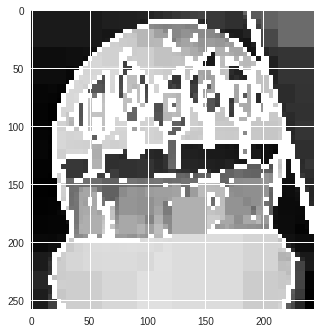

In [0]:
# Error Metrics and their thresholds
# 0: t = 1362, recursion_count = 1197
# 1: t = 29.7, recursion_count = 1195
# 2: t = 92.44, recursion_count = 1399

t1_qt = quadtree_wrapper(t3_gray, 0, 200)

plt.imshow(t1_qt)

In [0]:
index = np.arange(100).reshape(10,10)
print(index)
print()
vdiv = int(len(index)/2)
hdiv = int(len(index[0])/2)

# Mean Squared Error
print(index[:vdiv,:hdiv])
print( np.mean(( np.mean(index[:vdiv,:hdiv]) - index[:vdiv,:hdiv])**2 ) )


# print(np.mean((np.mean(index[:vdiv,:hdiv]) - index[:vdiv,:hdiv])**2))
# print()

# print(index[:vdiv, hdiv:])
# print(np.mean(index[:vdiv, hdiv:]))
# print()

print(index[vdiv:,:hdiv])
# print(np.mean(index[vdiv:,:hdiv]))
# print()


# print(index[vdiv:,hdiv:])
# print(np.mean(index[vdiv:,hdiv:]))
# print()

SyntaxError: ignored

References:
1.  Expanding tuples into arguments: https://stackoverflow.com/questions/1993727/expanding-tuples-into-arguments
2. Get key by value in dictionary: https://stackoverflow.com/questions/8023306/get-key-by-value-in-dictionary

## Median-cut compression

*Median cut is an algorithm to sort data of an arbitrary number of dimensions into series of sets by recursively cutting each set of data at the median point along the longest dimension.*

1. Find out which color channel (red, green, or blue) among the pixels in the bucket has the greatest range, then sort the pixels according to that channel's values. 
2. After the bucket has been sorted, move the upper half of the pixels into a new bucket. (It is this step that gives the median cut algorithm its name. The buckets are divided into two at the median of the list of pixels.) 
3. Repeat the process on both buckets



In [0]:
'''
--------------------------------
k-d tree data structure        |
Nodes in a tree                |
pt: image co-ordinates         |
val: intensity values          |
leftnode: less than median     |
rightnode: more than median    |
--------------------------------
'''

# class Node: 
#   def __init__(self, pt = None, val=None):
#     self.pt = pt
#     self.val = val
#     self.leftnode = leftnode
#     self.rightnode = rightnode

def channel_range(up, down, left, right):
  


References: 
1. Median-cut algorithm: https://en.wikipedia.org/wiki/Median_cut
2. K-d tree: https://en.wikipedia.org/wiki/K-d_tree

In [0]:
test_3d = np.arange(0,300).reshape(3, 10, 10)

np.max([np.ptp(test_3d[0]), np.ptp(test_3d[1]), np.ptp(test_3d[2])])

99

299